# Our Hypothesis: A* finds always the 'ShortBest' path!

Let's see, if this is true ...

In [1]:
#!pip install pandas

In [2]:
# Importations
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pandas as pd

from algorithms import *
from classes import *
from utils import *
from env_levels import *

# Our Static Environment

We've developed a custom environment using the **Minihack level editor** to gain precise control over our work. The environment we're working on is a 15x15 **fully observable maze**, where the agent navigates through the grid while avoiding hazardous **lava pools**.

The agent starts in the *top left corner* and needs to find the stairs in the *bottom right corner* while avoiding lava pools. 

Inside *env_levels.py* there is the *'.des-file'*:

* Agent: '@'
* Target: '>'
* Floor tile: '.'
* Walls: '-' and '|'
* Lava pools: 'L'

> As part of our exploration, we're committed to introducing and navigating through **various levels of complexity**. This initiative allows us to test and implement different search algorithms tailored to the evolving challenges presented by each level. This dynamic approach not only showcases the adaptability of our agent but also facilitates a comprehensive evaluation of its problem-solving capabilities across diverse scenarios.

For now, we: 
* initialize the specific map configuration
* set a random seed for reproducibility
* reset the environment to get the initial observation
* render the environment for visual representation

In [3]:
env_lv1 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv1,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv1.seed(42)
obs_lv1 = env_lv1.reset() #each reset generates a new environment instance
env_lv1.render()


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}.........|                                                                 
|.....}.....}.|                                                                 
|}............|                                                                 
|.}.......}...|                                                                 
|...}}..}.....|                                                                 
|.}.........}.|                                                                 
|....}..}.....|                                                                 
|.}........}.}|            

In [4]:
env_lv1.actions

(<CompassDirection.N: 107>,
 <CompassDirection.E: 108>,
 <CompassDirection.S: 106>,
 <CompassDirection.W: 104>,
 <CompassDirection.NE: 117>,
 <CompassDirection.SE: 110>,
 <CompassDirection.SW: 98>,
 <CompassDirection.NW: 121>)

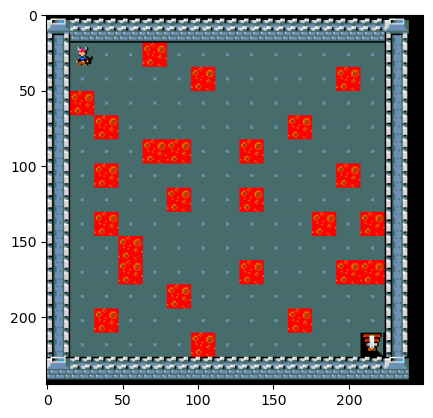

In [5]:
plt.imshow(obs_lv1['pixel'][45:290, 0:250]) #Plots directly from minihack generator

In [6]:
game = obs_lv1['pixel']

In [7]:
comparison_case1 = []
comparison_case2 = []
comparison_case3 = []
comparison_case4 = []
algorithms = ['Breadth First Search (UA)', 'Uniform Cost Search (UA)', 'A* (IA)', 'Greedy Best First Search (IA)']
time_case1 = []
path_case1 = []
path_cost_case1 = []
time_case2 = []
path_case2 = []
path_cost_case2 = []
time_case3 = []
path_case3 = []
path_cost_case3 = []
time_case4 = []
path_case4 = []
path_cost_case4 = []

## A GridWorld Problem

To streamline the implementation of search algorithms in our agent, we've established a problem definition encapsulated within a class. Specifically, we've conceptualized our problem using a **GridWorldProblem class**. This class serves as a foundation for formulating the problem in a way that aligns with the principles of graph search algorithms.

As these search algorithms operate on graphs, we visualize the **corresponding graph of the agent's environment**. This graph effectively represents the navigable nodes within the maze, and we highlight the coordinates of each node for clarity. The edges connecting these states within the graph are assigned a uniform cost of 1.

In our case we will consider the _chars_ representation, a multi-dimensional array containing the ASCII encoding of the characters. More specifically:

* Agent: ASCII 64
* Stairs: ASCII 62
* Walls: ASCII
* Lava: ASCII 125

> To ensure an accurate and meaningful representation of the maze environment within the graph, we undertake a crucial **preprocessing step**. This step involves meticulous manipulation of the Minihack matrix, allowing us to narrow our focus exclusively to the observable aspects of the environment.

In [8]:
game_map_lv1 = process_matrix(obs_lv1['chars'])
print(game_map_lv1)

[[ 45  45  45  45  45  45  45  45  45  45  45  45  45  45  45]
 [124  64  46  46 125  46  46  46  46  46  46  46  46  46 124]
 [124  46  46  46  46  46 125  46  46  46  46  46 125  46 124]
 [124 125  46  46  46  46  46  46  46  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46 125  46  46  46 124]
 [124  46  46  46 125 125  46  46 125  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46  46  46 125  46 124]
 [124  46  46  46  46 125  46  46 125  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46  46 125  46 125 124]
 [124  46  46 125  46  46  46  46  46  46  46  46  46  46 124]
 [124  46  46 125  46  46  46  46 125  46  46  46 125 125 124]
 [124  46  46  46  46 125  46  46  46  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46 125  46  46  46 124]
 [124  46  46  46  46  46 125  46  46  46  46  46  46  62 124]
 [ 45  45  45  45  45  45  45  45  45  45  45  45  45  45  45]]


In [9]:
process_matrix(obs_lv1['colors'])
# 6 -> blue
# 1 -> red
game_map_lv1_colors = process_matrix(obs_lv1['colors'])

Initial state: (1, 1)
Goal state: (13, 13)


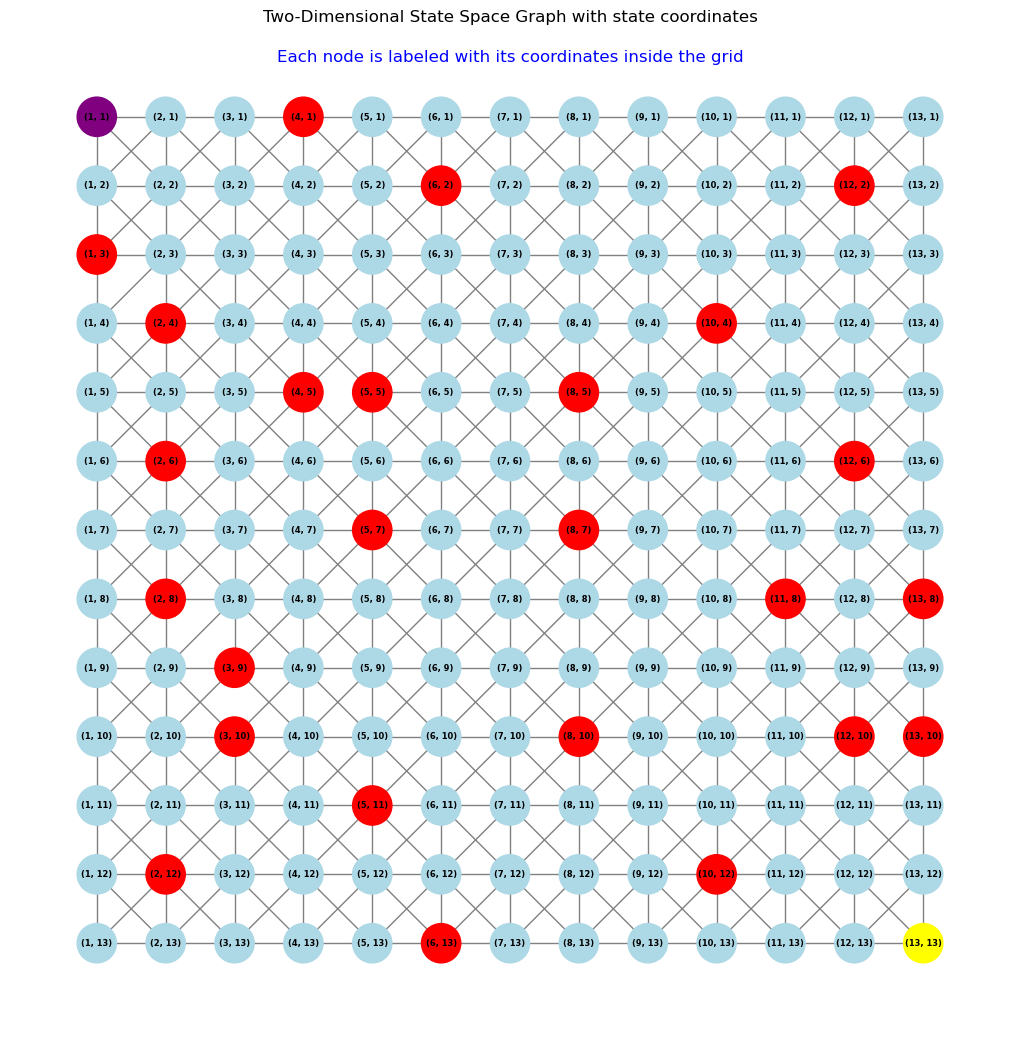

In [10]:
grid_problem1 = GridWorldProblem(game_map_lv1, find_state_coord(game_map_lv1, ord('@')), find_state_coord(game_map_lv1, ord('>')), game_map_lv1_colors)

print("Initial state:", grid_problem1.initial_state)
print("Goal state:", grid_problem1.goal_state)

basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)

plot_graph(basic_graph)

## <u> CASE 1 </u>

### Uninformed Agent (Breadth-First-Search)

Our uninformed agent employs the Breadth-First Search (BFS) algorithm to navigate through the grid world problem.

* Red Nodes: Lava pools.
* Green Nodes: Nodes visited by the agent
* Blue Node: Initial position of the agent

> This visualization provides a clear depiction of the agent's exploration process, distinguishing between hazardous areas (lava pools), traversed paths, and the starting point of the agent. The Breadth-First Search algorithm ensures a systematic exploration of the grid, contributing to efficient pathfinding in our maze-like environment.

Time: 0.002711 seconds
The found path is long 20.
The cost of the taken path is 20.


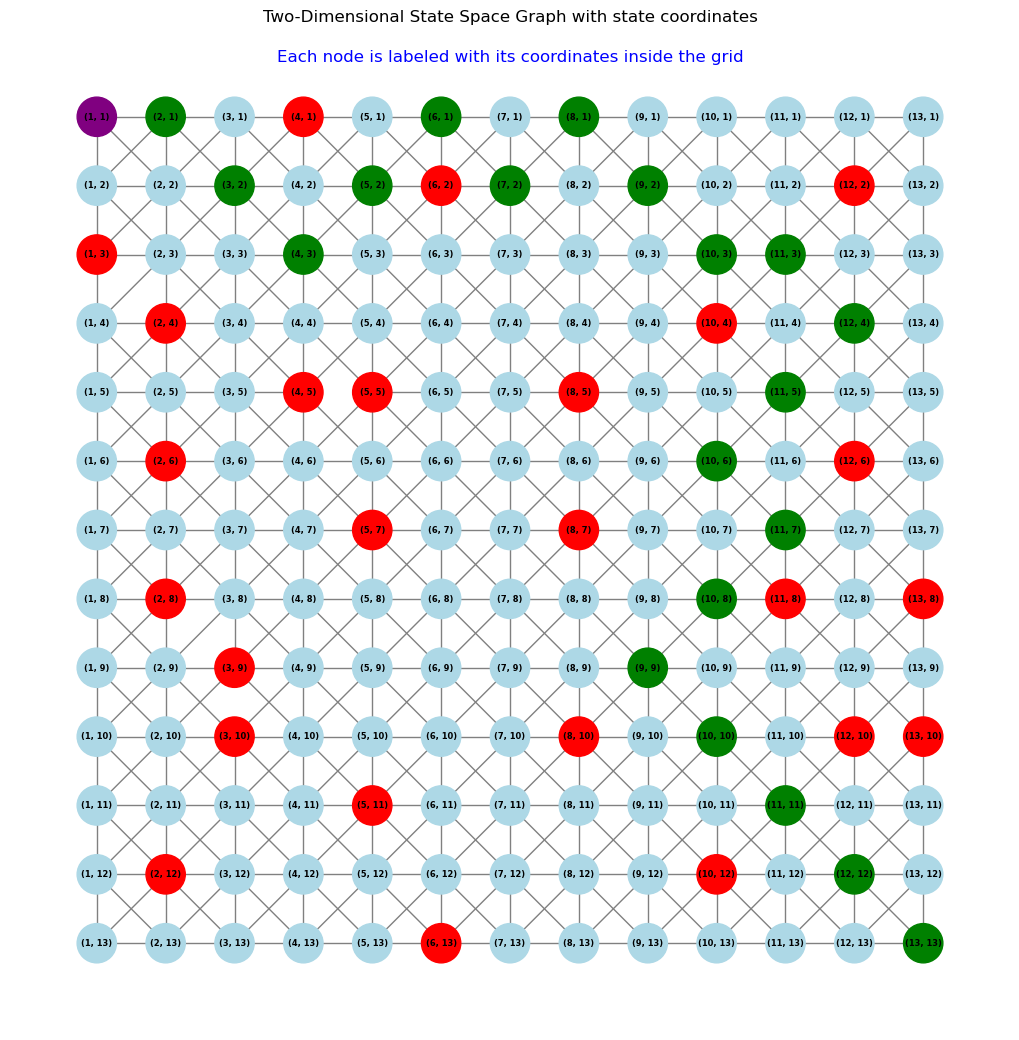

In [11]:
uninformed_agent = UninformedSearchAgent(grid_problem1) # Instantiate an Uninformed Search Agent

solution_path = uninformed_agent.search(breadth_first_search) # Perform uniformed search with the Breadth-First Search

time_case1.append(uninformed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Cost path computation
path_cost_case1.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

plot_graph(explored_graph) # Plot the graph with both basic and explored nodes

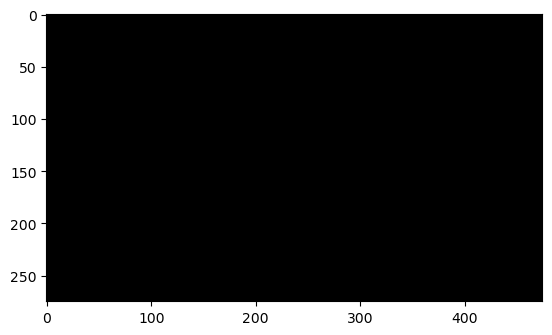

In [12]:
# PLOT
actions = actions_from_path(find_state_coord(game_map_lv1, ord('@')), solution_path)

import IPython.display as display

image = plt.imshow(game[25:300, :475])
for action in actions:
    s, _, _, _ = env_lv1.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][25:300, :475])
    time.sleep(0.3)

### Uninformed Agent (Dijkstra's Algorithm) 

Time: 0.011873 seconds
The taken path has the length 14 (steps).
The cost of the taken path is 14.


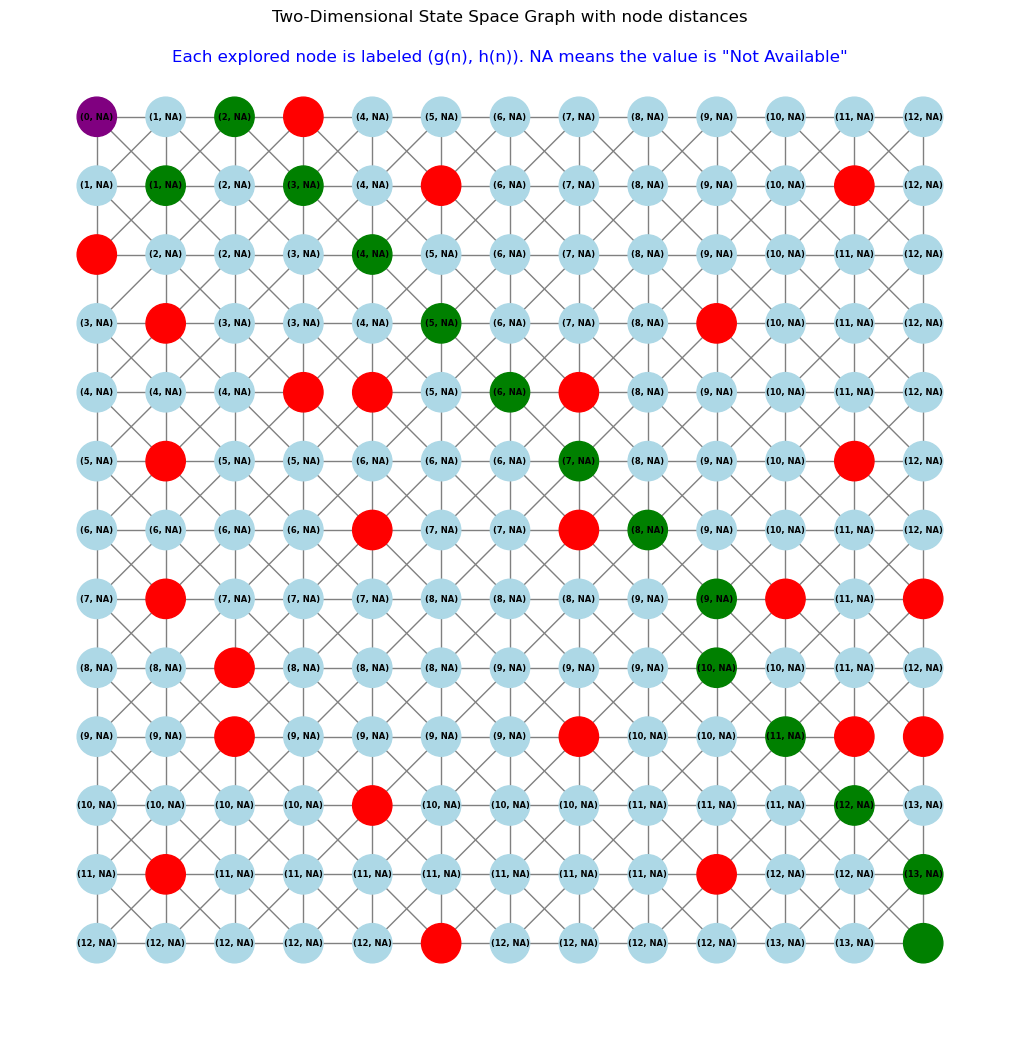

In [13]:
uninformed_agent = UninformedSearchAgent(grid_problem1)
solution_path, node_distances = uninformed_agent.search(uniform_cost_search)

time_case1.append(uninformed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The taken path has the length {len(solution_path)} (steps).')

# Cost path computation
path_cost_case1.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (A*)

Time: 0.013674 seconds
The found path is long 13
The cost of the taken path is 13.


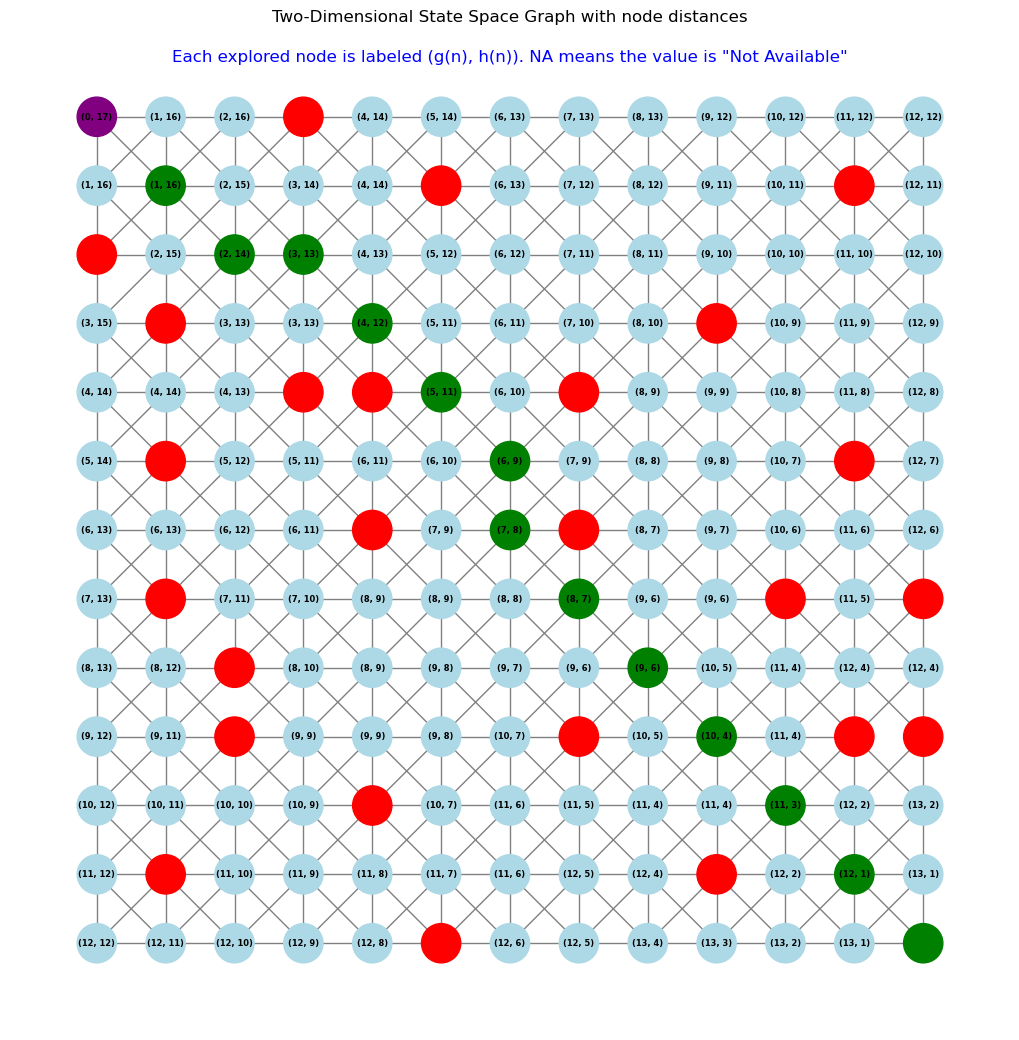

In [14]:
informed_agent = InformedSearchAgent(grid_problem1)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(astar_search, euclidean_distance)

time_case1.append(informed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case1.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)


# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (Greedy Best First Search)

Time: 0.000436 seconds
The found path is long 15
The cost of the taken path is 15.


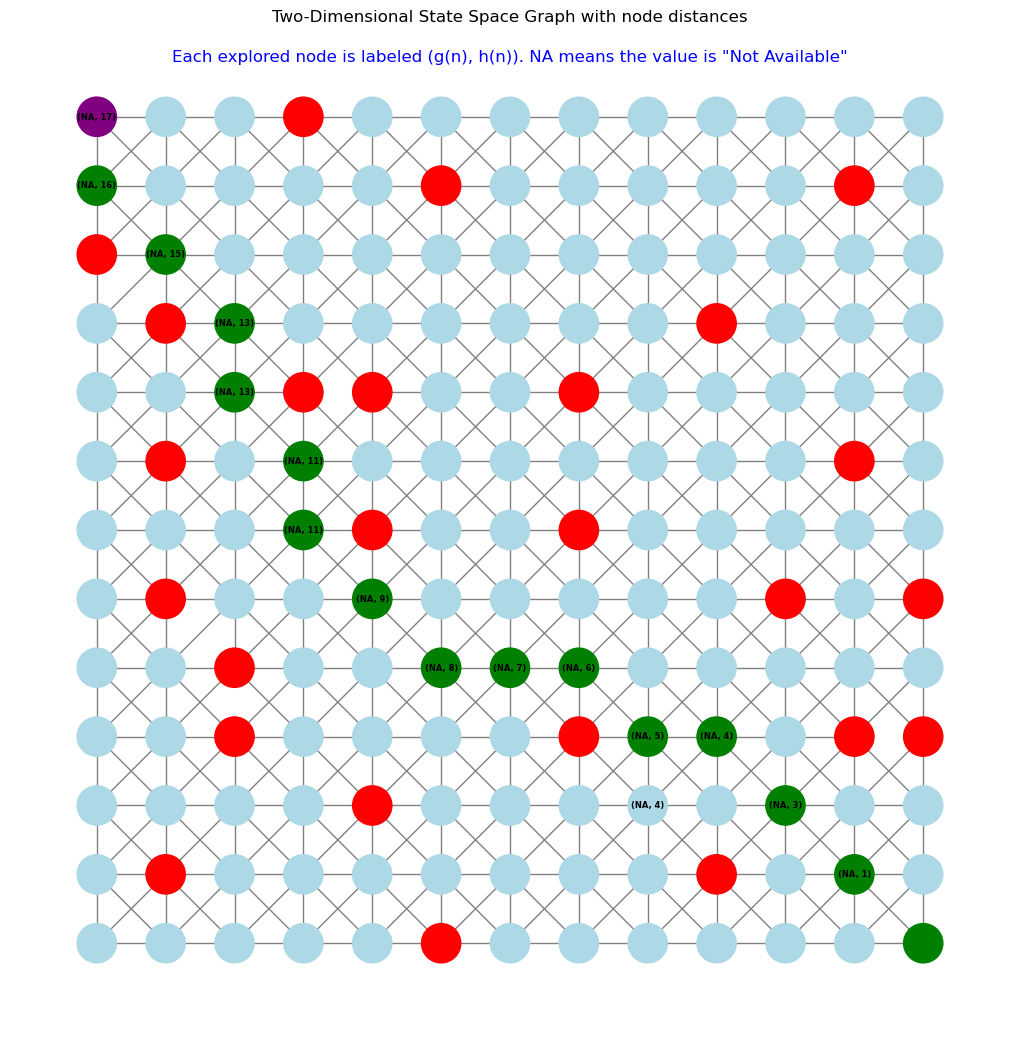

In [15]:
informed_agent = InformedSearchAgent(grid_problem1)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(greedy_best_first_search, euclidean_distance)

time_case1.append(informed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case1.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

## CASE 1: Performance Evaluation and Comparison of Search Algorithms

In [16]:
comparison_case1.append(algorithms)
comparison_case1.append(time_case1)
comparison_case1.append(path_case1)
comparison_case1.append(path_cost_case1)
df_case1 = pd.DataFrame()
df_case1['Algorithm'] = algorithms
df_case1['Execution Time'] = time_case1
df_case1['Path Length'] = path_case1
df_case1['Path Cost'] = path_cost_case1
df_case1.set_index('Algorithm', inplace=True)
df_case1

Execution Time  Path Length  Path Cost
Algorithm                                                            
Breadth First Search (UA)            0.002711           20         20
Uniform Cost Search (UA)             0.011873           14         14
A* (IA)                              0.013674           13         13
Greedy Best First Search (IA)        0.000436           15         15

## <u> CASE 2 </u>
To increase the complexity of the environment and to test, how the algorithms work, we add more lava pools.

In [17]:
env_lv2 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv2,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv2.seed(42)
obs_lv2 = env_lv2.reset() #each reset generates a new environment instance
env_lv2.render()


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}...}.}...|                                                                 
|.....}.....}.|                                                                 
|}..}.}.......|                                                                 
|.}.......}..}|                                                                 
|...}}..}.....|                                                                 
|..}........}.|                                                                 
|..}.}...}}...|                                                                 
|.}..}..}}.}..|            

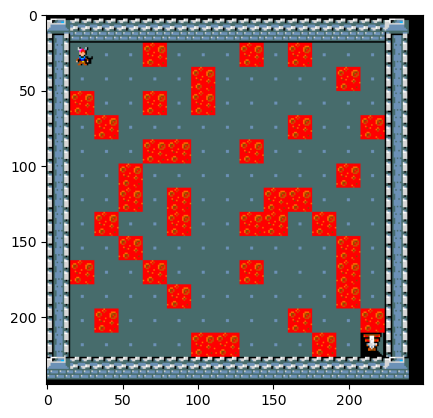

In [18]:
plt.imshow(obs_lv2['pixel'][45:290, 0:250]) #Plots directly from minihack generator

game_map_lv2 = process_matrix(obs_lv2['chars'])

game_map_lv2_colors = process_matrix(obs_lv2['colors'])

Initial state: (1, 1)
Goal state: (13, 13)


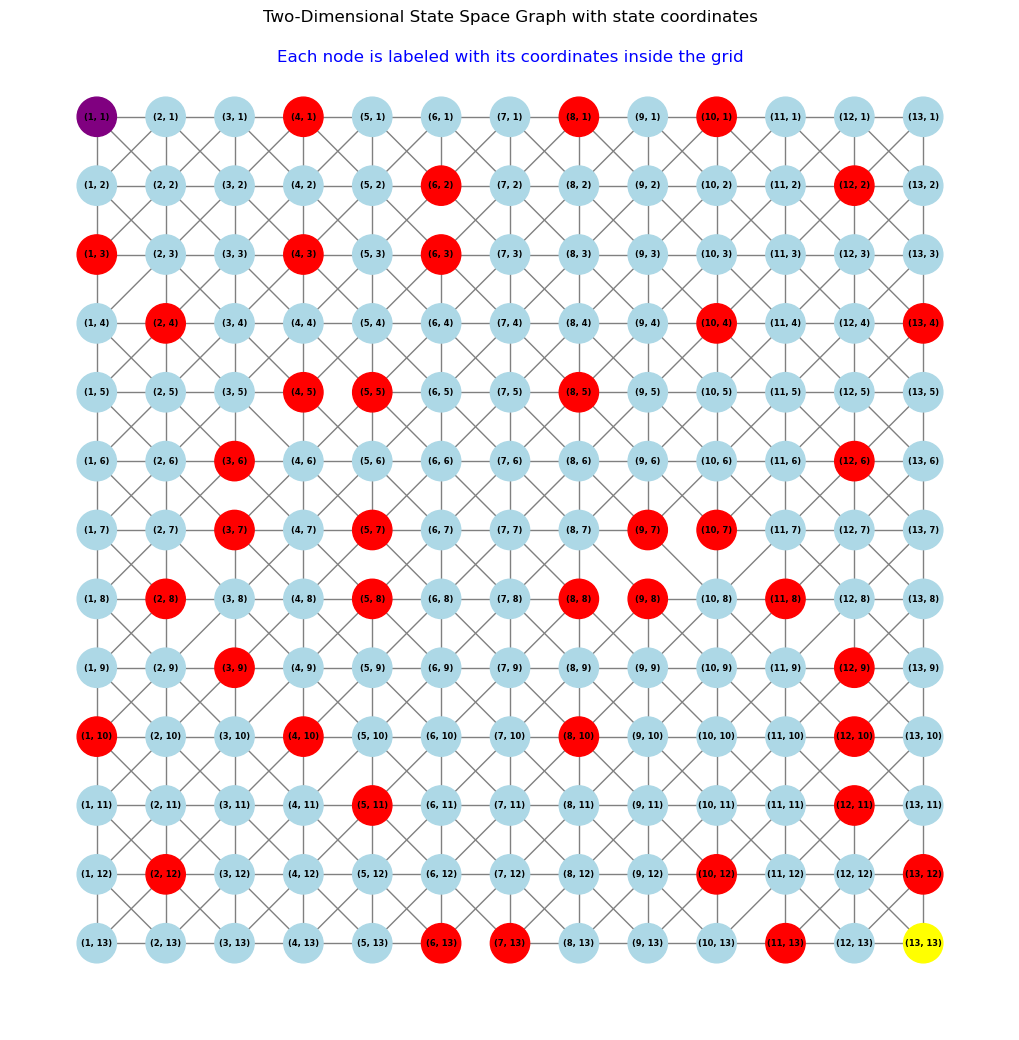

In [19]:
grid_problem2 = GridWorldProblem(game_map_lv2, find_state_coord(game_map_lv2, ord('@')), find_state_coord(game_map_lv2, ord('>')), game_map_lv2_colors)

print("Initial state:", grid_problem2.initial_state)
print("Goal state:", grid_problem2.goal_state)

basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)

plot_graph(basic_graph)

### Uninformed Agent (Breadth-First-Search)

Time: 0.002048 seconds
The found path is long 19.
The cost of the taken path is 19.


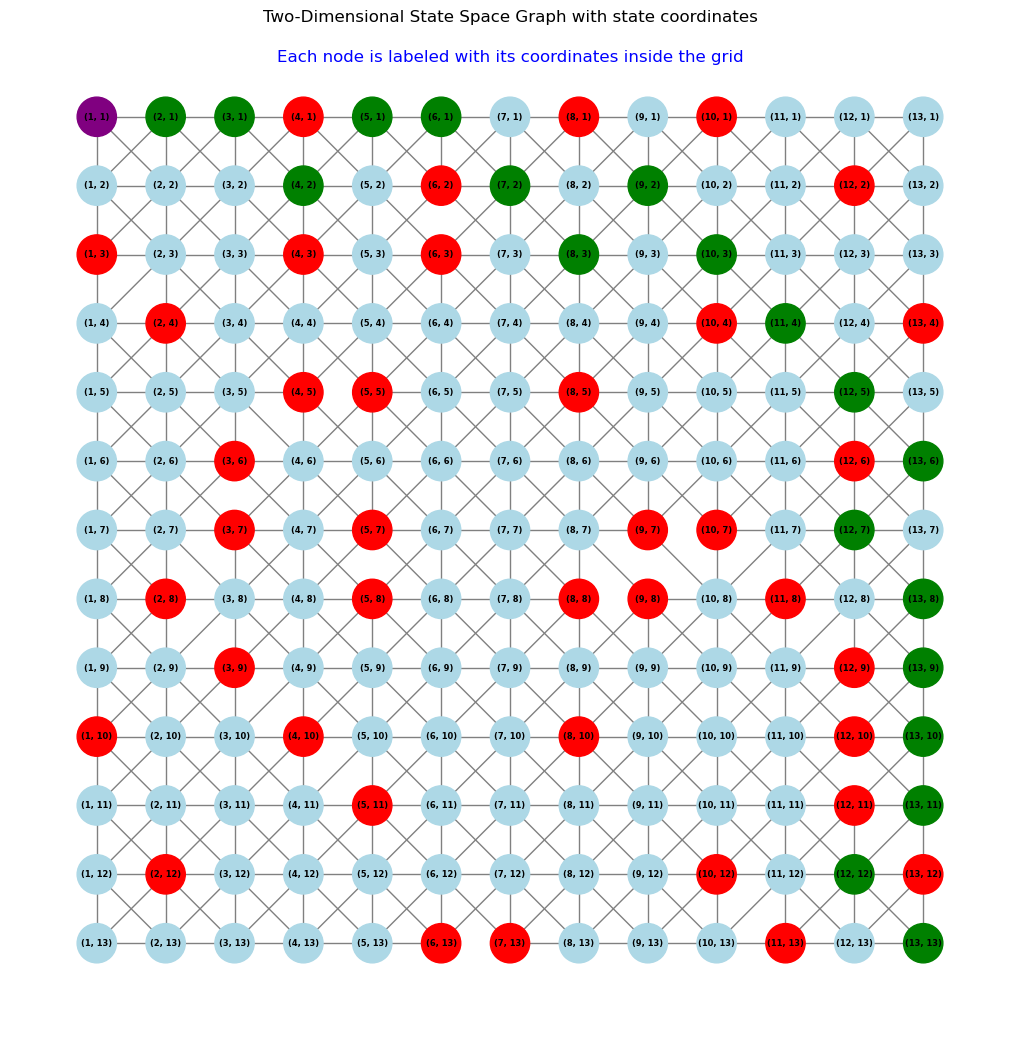

In [20]:

uninformed_agent = UninformedSearchAgent(grid_problem2) # Instantiate an Uninformed Search Agent

solution_path = uninformed_agent.search(breadth_first_search) # Perform uniformed search with the Breadth-First Search

time_case2.append(uninformed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Cost path computation
path_cost_case2.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

plot_graph(explored_graph) # Plot the graph with both basic and explored nodes

### Uninformed Agent (Dijkstra's Algorithm)

Time: 0.009652 seconds
The found path is long 14.
The cost of the taken path is 14.


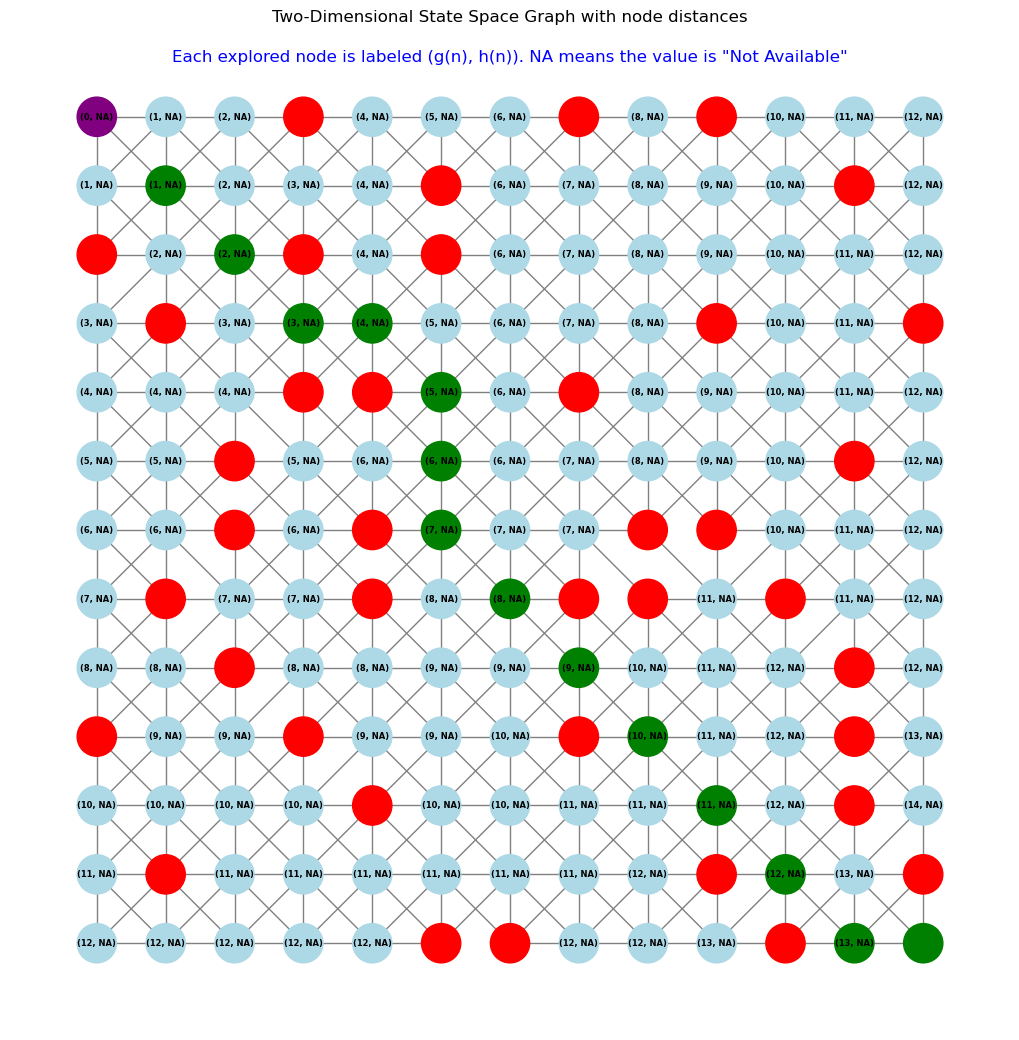

In [21]:
uninformed_agent = UninformedSearchAgent(grid_problem2)
solution_path, node_distances = uninformed_agent.search(uniform_cost_search)

time_case2.append(uninformed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Cost path computation
path_cost_case2.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (A*)

Time: 0.009611 seconds
The found path is long 14
The cost of the taken path is 14.


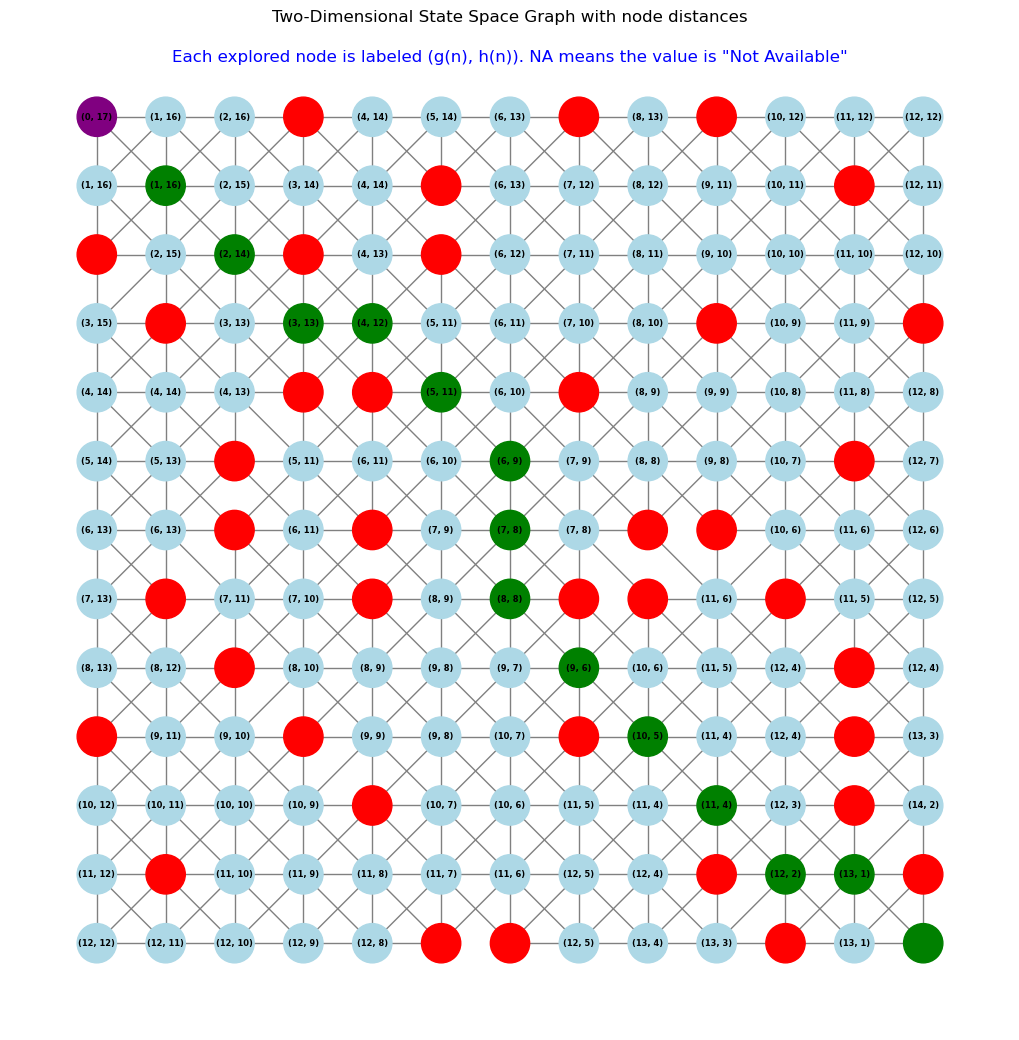

In [22]:
informed_agent = InformedSearchAgent(grid_problem2)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(astar_search, euclidean_distance)

time_case2.append(informed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case2.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (Greedy Best-First Search)

Time: 0.001357 seconds
The found path is long 16
The cost of the taken path is 16.


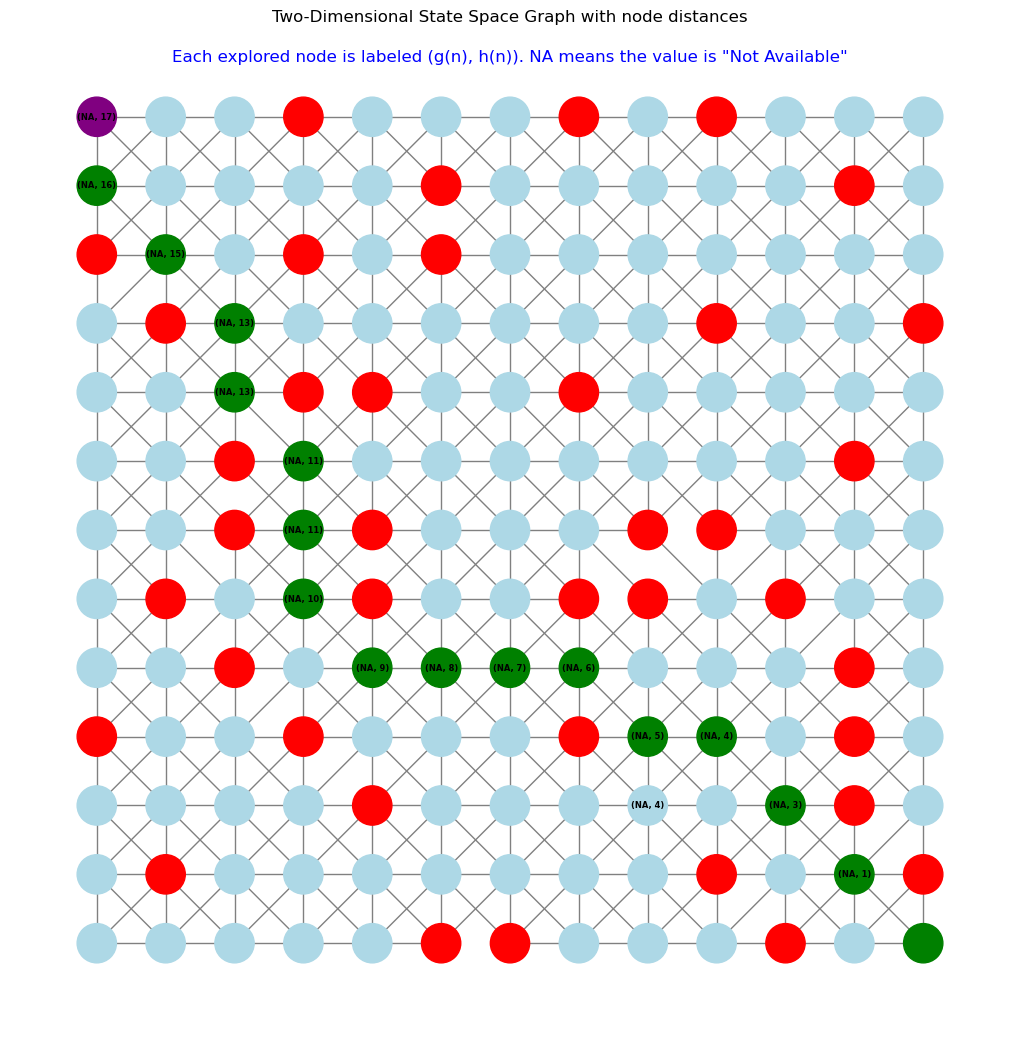

In [23]:
informed_agent = InformedSearchAgent(grid_problem2)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(greedy_best_first_search, euclidean_distance)

time_case2.append(informed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case2.append(len(solution_path)*1)
print(f'The cost of the taken path is {len(solution_path)*1}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

In [24]:
comparison_case2.append(algorithms)
comparison_case2.append(time_case2)
comparison_case2.append(path_case2)
comparison_case2.append(path_cost_case2)
df_case2 = pd.DataFrame()
df_case2['Algorithm'] = algorithms
df_case2['Execution Time'] = time_case2
df_case2['Path Length'] = path_case2
df_case2['Path Cost'] = path_cost_case2
df_case2.set_index('Algorithm', inplace=True)
df_case2

Execution Time  Path Length  Path Cost
Algorithm                                                            
Breadth First Search (UA)            0.002048           19         19
Uniform Cost Search (UA)             0.009652           14         14
A* (IA)                              0.009611           14         14
Greedy Best First Search (IA)        0.001357           16         16

## <u> CASE 3 </u>
### Create the Environment


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}...}.}...|                                                                 
|.....}.....}.|                                                                 
|}..}.}.......|                                                                 
|.}.......}..}|                                                                 
|...}}..}.....|                                                                 
|..}........}.|                                                                 
|..}.}...}}...|                                                                 
|.}..}..}}.}..|            

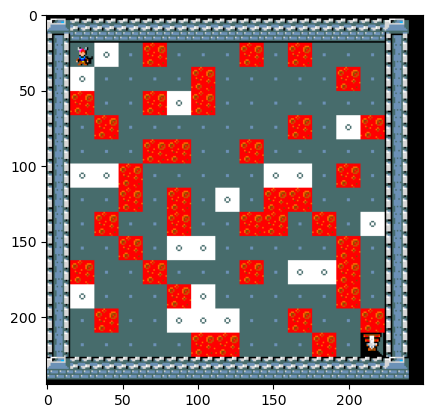

In [25]:
env_lv3 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv3,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv3.seed(42)
obs_lv3 = env_lv3.reset() #each reset generates a new environment instance
env_lv3.render()

plt.imshow(obs_lv3['pixel'][45:290, 0:250]) #Plots directly from minihack generator

game_map_lv3 = process_matrix(obs_lv3['chars'])
game_map_lv3_colors = process_matrix(obs_lv3['colors'])

### General Problem

Initial state: (1, 1)
Goal state: (13, 13)


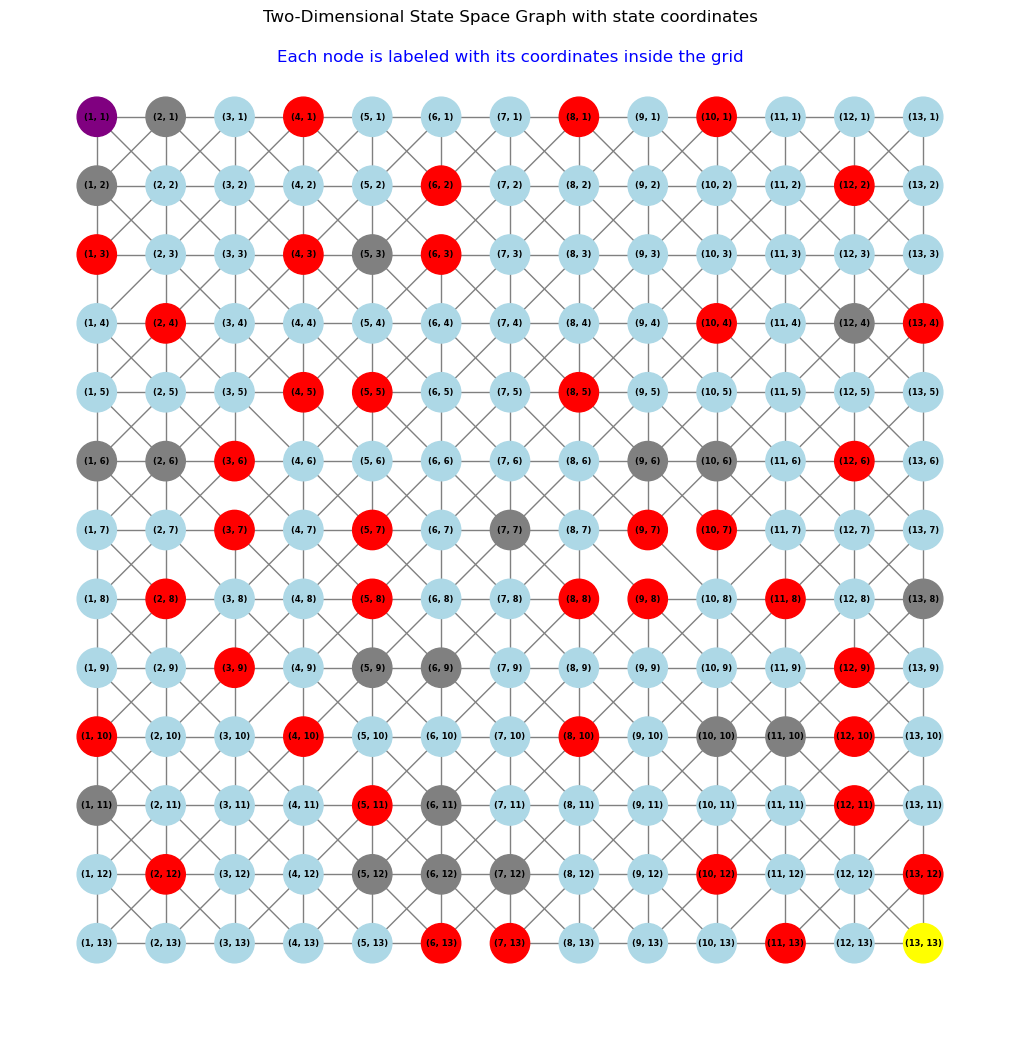

In [26]:
# Instantiate a problem from class GridWorldProblem
grid_problem3 = GridWorldProblem(game_map_lv3, find_state_coord(game_map_lv3, ord('@')), find_state_coord(game_map_lv3, ord('>')), game_map_lv3_colors)

print("Initial state:", grid_problem3.initial_state)
print("Goal state:", grid_problem3.goal_state)

# Create the basic graph
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)

plot_graph(basic_graph)

### Uninformed Agent (Breadth-First Search)

Time: 0.001545 seconds
The found path is long 19.
The cost of the taken path is 23.


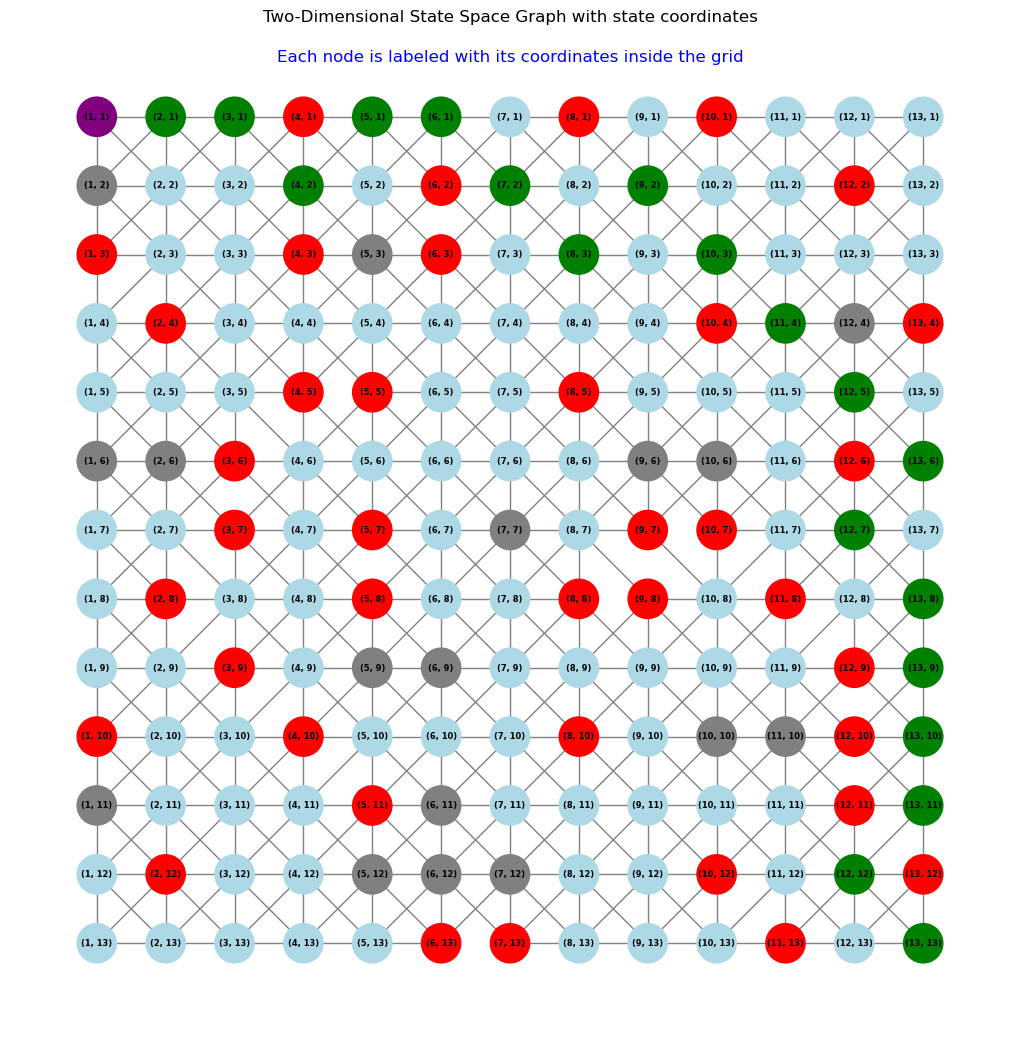

In [27]:
uninformed_agent = UninformedSearchAgent(grid_problem3)
solution_path = uninformed_agent.search(breadth_first_search)

time_case3.append(uninformed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Cost path computation
path_cost_case3.append(cost_computation(game_map_lv3, game_map_lv3_colors, solution_path))
print(f'The cost of the taken path is {cost_computation(game_map_lv3, game_map_lv3_colors, solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph(explored_graph)

### Uninformed Agent (Dijkstra's Algorithm)

Time: 0.010454 seconds
The taken path has the length 14 (steps).
The cost of the taken path is 14.


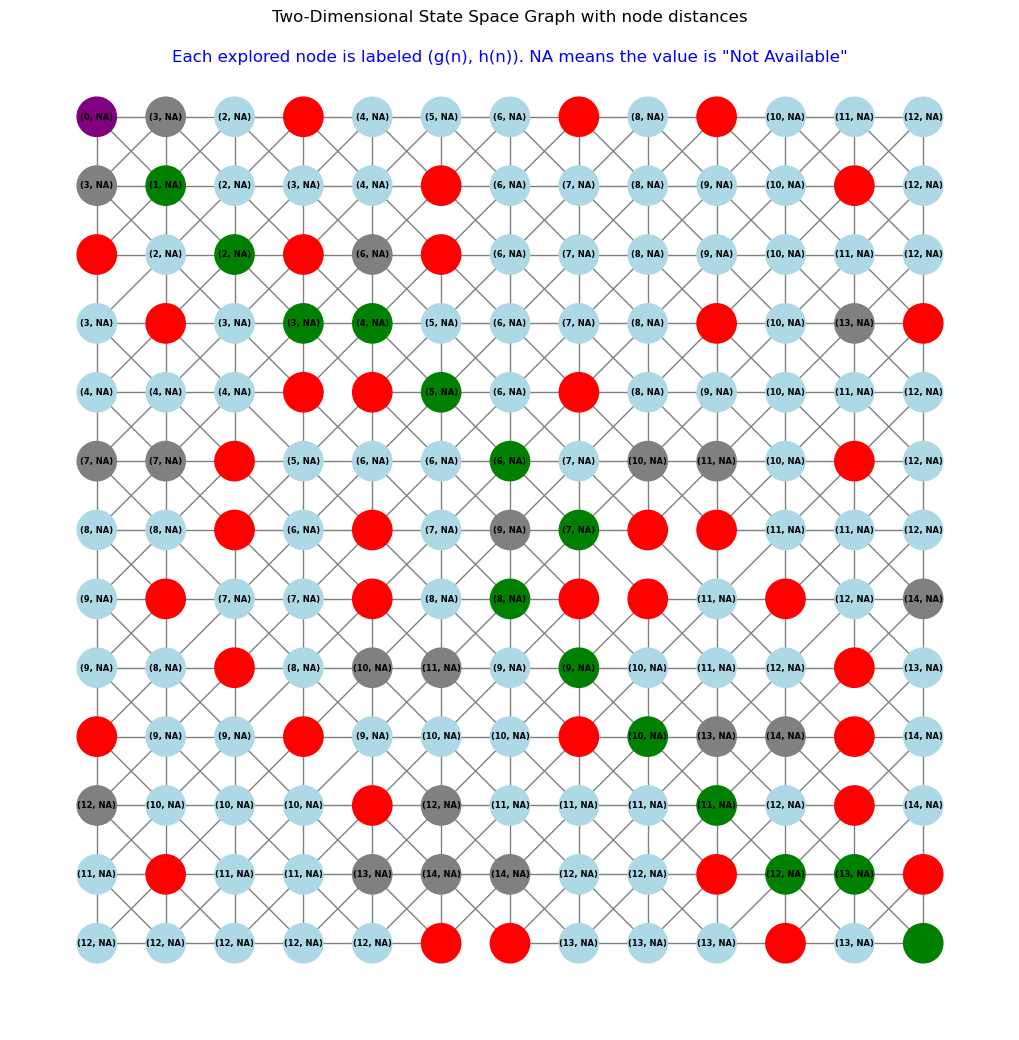

In [28]:
uninformed_agent = UninformedSearchAgent(grid_problem3)
solution_path, node_distances = uninformed_agent.search(uniform_cost_search)

time_case3.append(uninformed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The taken path has the length {len(solution_path)} (steps).')

# Cost path computation
path_cost_case3.append(cost_computation(game_map_lv3, game_map_lv3_colors, solution_path))
print(f'The cost of the taken path is {cost_computation(game_map_lv3, game_map_lv3_colors, solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (A*)

Time: 0.007884 seconds
The found path is long 14
The cost of the taken path is 14.


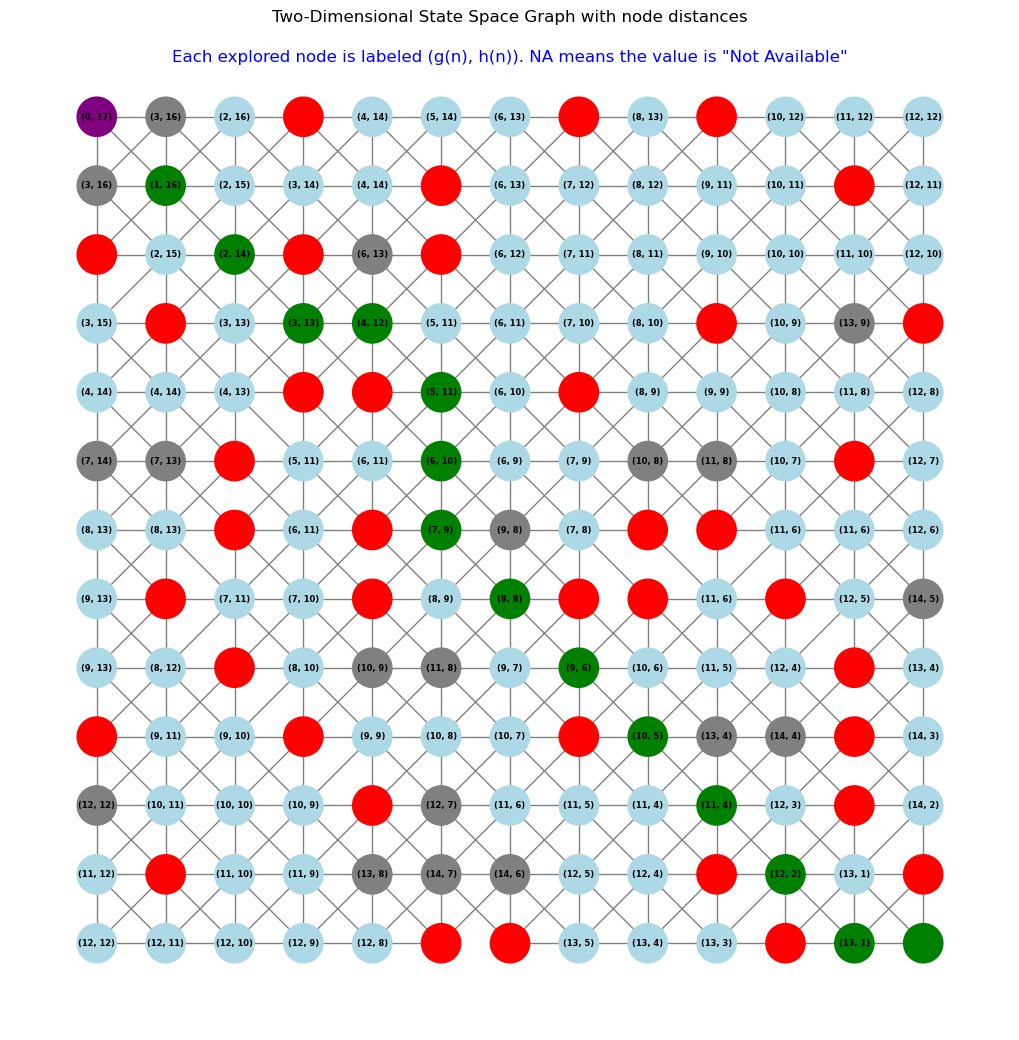

In [29]:
informed_agent = InformedSearchAgent(grid_problem3)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(astar_search, euclidean_distance)

time_case3.append(informed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case3.append(cost_computation(game_map_lv3, game_map_lv3_colors, solution_path))
print(f'The cost of the taken path is {cost_computation(game_map_lv3, game_map_lv3_colors, solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (Greedy Best-First-Search)

Time: 0.000675 seconds
The found path is long 16
The cost of the taken path is 24.


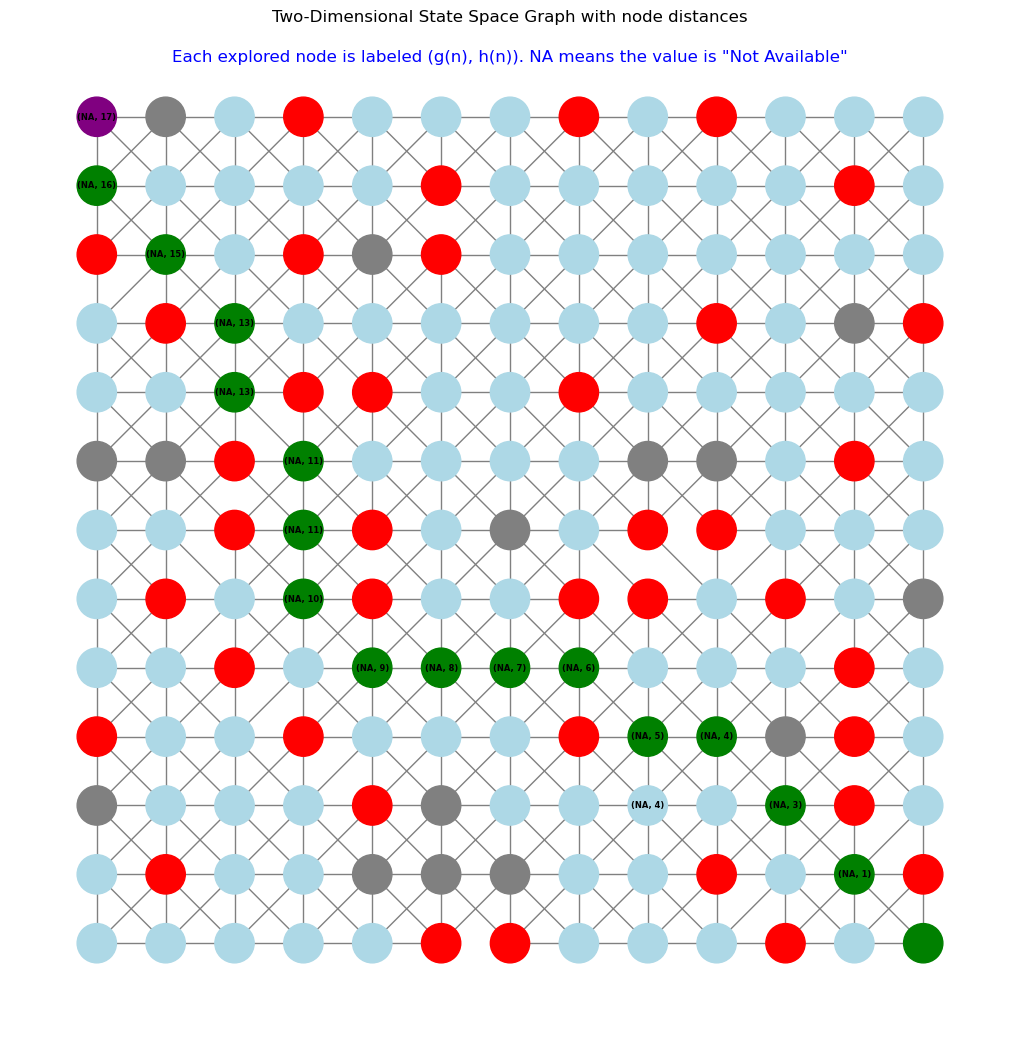

In [30]:

informed_agent = InformedSearchAgent(grid_problem3)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(greedy_best_first_search, euclidean_distance)

time_case3.append(informed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case3.append(cost_computation(game_map_lv3, game_map_lv3_colors, solution_path))
print(f'The cost of the taken path is {cost_computation(game_map_lv3, game_map_lv3_colors, solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

In [31]:
comparison_case3.append(algorithms)
comparison_case3.append(time_case3)
comparison_case3.append(path_case3)
comparison_case3.append(path_cost_case3)
df_case3 = pd.DataFrame()
df_case3['Algorithm'] = algorithms
df_case3['Execution Time'] = time_case3
df_case3['Path Length'] = path_case3
df_case3['Path Cost'] = path_cost_case3
df_case3.set_index('Algorithm', inplace=True)
df_case3

Execution Time  Path Length  Path Cost
Algorithm                                                            
Breadth First Search (UA)            0.001545           19         23
Uniform Cost Search (UA)             0.010454           14         14
A* (IA)                              0.007884           14         14
Greedy Best First Search (IA)        0.000675           16         24

## <u> CASE 4 </u>
### Create the Environment


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}...}.}...|                                                                 
|.....}.....}.|                                                                 
|}..}.}.......|                                                                 
|.}.......}..}|                                                                 
|...}}..}.....|                                                                 
|..}........}.|                                                                 
|..}.}...}}...|                                                                 
|.}..}..}}.}..|            

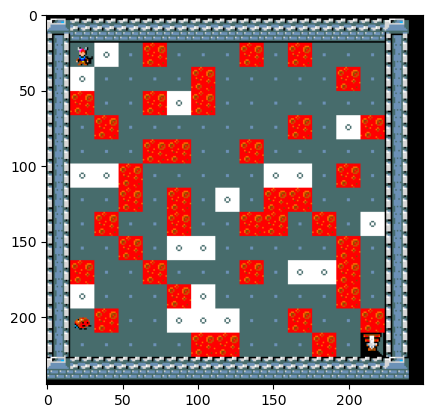

In [32]:
env_lv4 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv4,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv4.seed(42)
obs_lv4 = env_lv4.reset() #each reset generates a new environment instance
env_lv4.render()

plt.imshow(obs_lv4['pixel'][45:290, 0:250]) #Plots directly from minihack generator

game_map_lv4 = process_matrix(obs_lv4['chars'])
game_map_lv4_colors = process_matrix(obs_lv4['colors'])

### General Problem

Initial state: (1, 1)
Goal state: (13, 13)


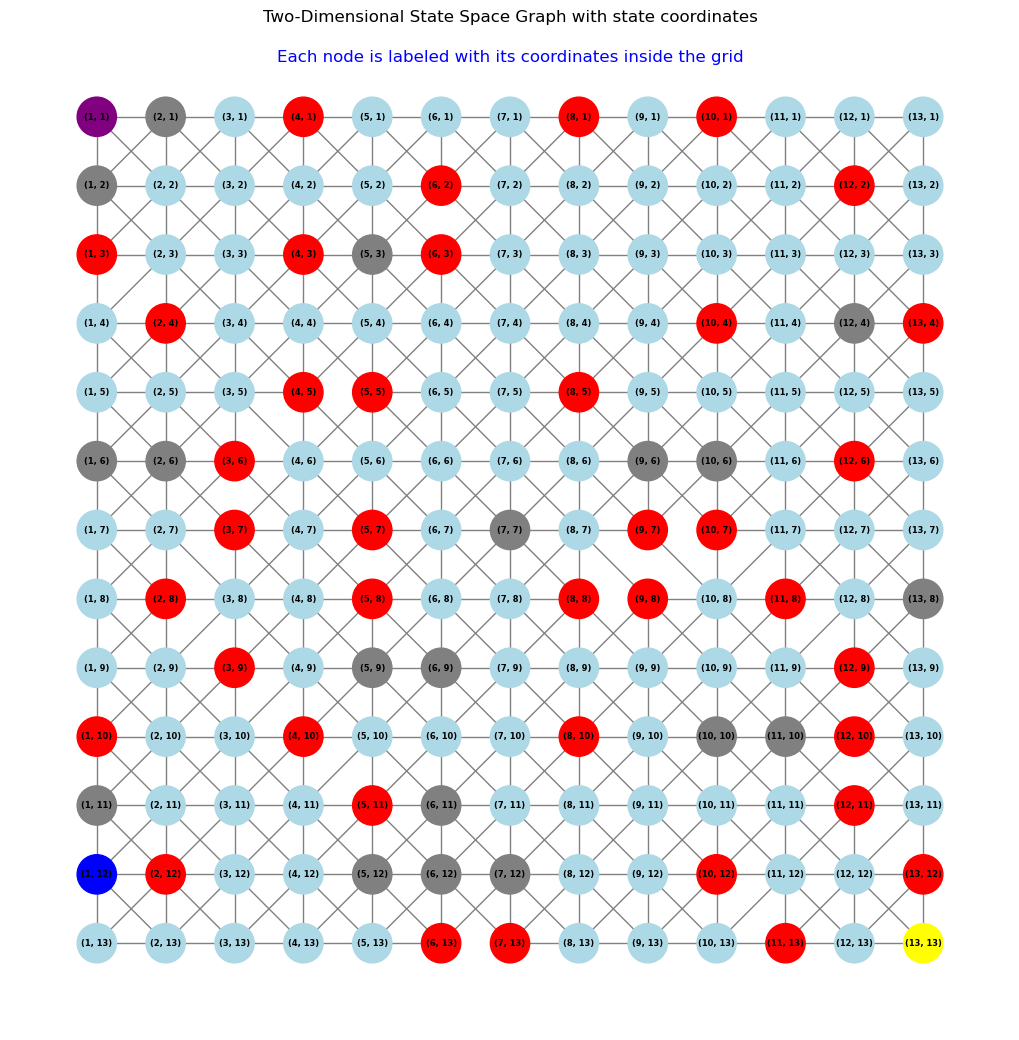

In [33]:
# Instantiate a problem from class GridWorldProblem
grid_problem4 = GridWorldProblem(game_map_lv4, find_state_coord(game_map_lv4, ord('@')), find_state_coord(game_map_lv4, ord('>')), game_map_lv4_colors)

print("Initial state:", grid_problem4.initial_state)
print("Goal state:", grid_problem4.goal_state)

# Create the basic graph
basic_graph = create_basic_graph(grid_problem4, grid_problem4.initial_state)

plot_graph(basic_graph)

### Informed Agent (online A*)

Time: 0.01565 seconds
The found path is long 21
The cost of the taken path is 25.


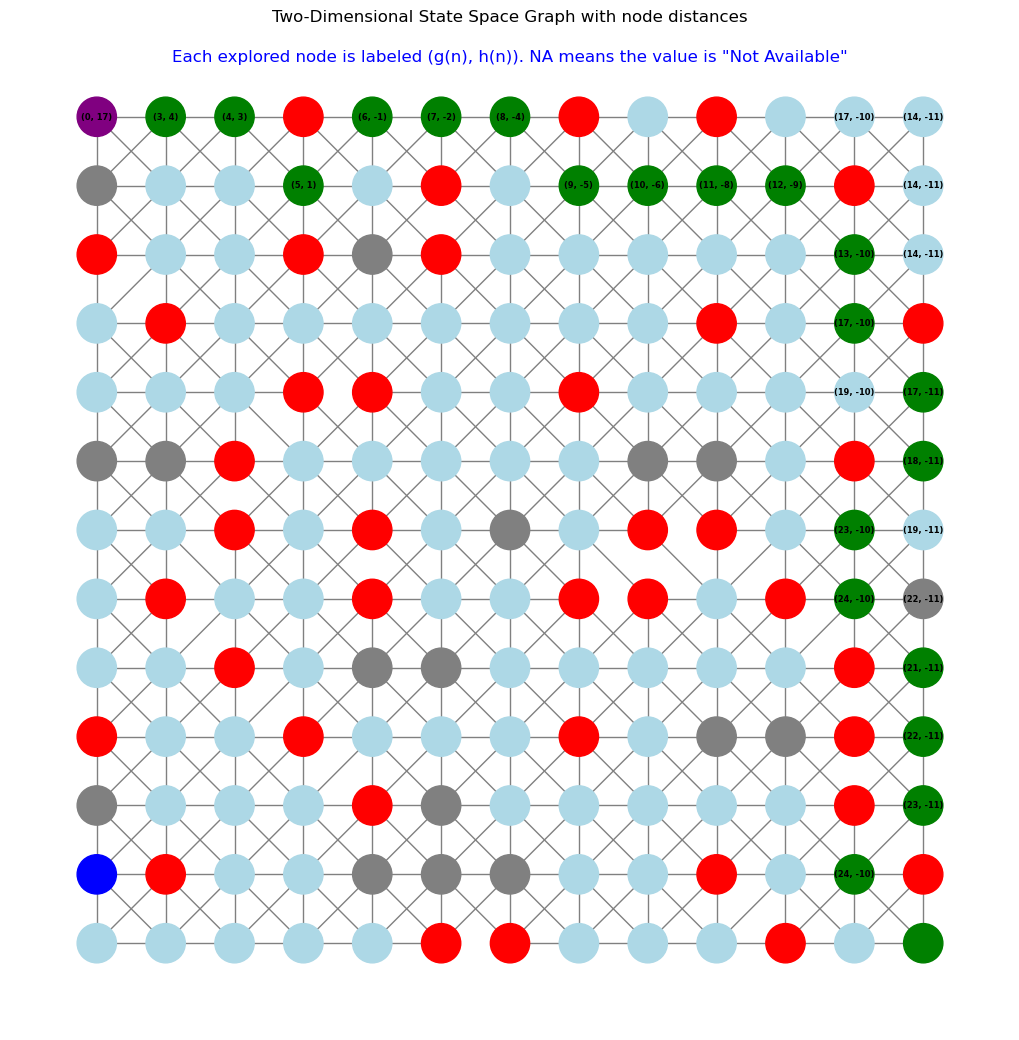

In [34]:
informed_agent = InformedSearchAgent(grid_problem4)
solution_path, explored_nodes_paths, node_distances, enemy_positions = informed_agent.search2(lrta_star_search, euclidean_distance)

time_case4.append(informed_agent.execution_time())
path_case4.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Cost path computation
path_cost_case4.append(cost_computation(game_map_lv4, game_map_lv4_colors, solution_path))
print(f'The cost of the taken path is {cost_computation(game_map_lv4, game_map_lv4_colors, solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem4, grid_problem4.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)
#explored_graph_by_enemy = highlight_explored_nodes_by_enemy(explored_graph, enemy_po)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

In [35]:
enemy_positions # ERRORE

[(1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12)]

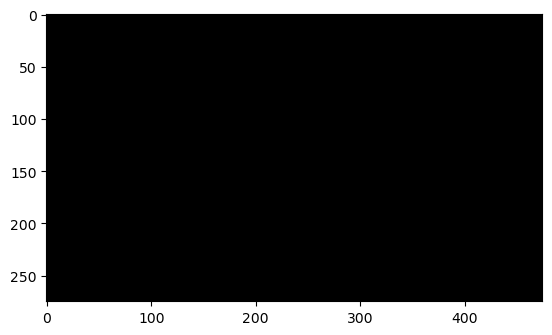

In [36]:
# PLOT
actions = actions_from_path(find_state_coord(game_map_lv4, ord('@')), solution_path)

import IPython.display as display

image = plt.imshow(game[25:300, :475])
for action in actions:
    s, _, _, _ = env_lv4.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][25:300, :475])
    time.sleep(0.3)

In [37]:
print("Case 1:")
print(df_case1)
print("\nCase 2:")
print(df_case2)
print("\nCase 3:")
print(df_case3)

Case 1:
                               Execution Time  Path Length  Path Cost
Algorithm                                                            
Breadth First Search (UA)            0.002711           20         20
Uniform Cost Search (UA)             0.011873           14         14
A* (IA)                              0.013674           13         13
Greedy Best First Search (IA)        0.000436           15         15

Case 2:
                               Execution Time  Path Length  Path Cost
Algorithm                                                            
Breadth First Search (UA)            0.002048           19         19
Uniform Cost Search (UA)             0.009652           14         14
A* (IA)                              0.009611           14         14
Greedy Best First Search (IA)        0.001357           16         16

Case 3:
                               Execution Time  Path Length  Path Cost
Algorithm                                                       